### 3D City Models from Volunteered Public Data

**This notebook will produce:**

> **1. an interactive 3D Building Model visualization** *- via [pydeck](https://deckgl.readthedocs.io/en/latest/) - which a user can navigate and query* **and**;  
>
> **2. allow the user to execute an application of Spatial Data Science**  
>
>> **i)  population estimation and**  
>> **ii)  a measure of [Building Volume per Capita](https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs).**

In [74]:
#load the magic

%matplotlib inline
import os
from pathlib import Path
import requests

import overpass
import osm2geojson

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, shape, mapping
#shapely.speedups.disable()
import json
import geojson
import topojson as tp

from osgeo import ogr

from openlocationcode import openlocationcode as olc

import matplotlib.pyplot as plt
import pydeck as pdk

## 1. Interactive Visualization

**Harvest [OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap)** - Query the [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) from within Jupyter and convert to .geojson.

<div class="alert alert-block alert-info"><b>Set an area-of-interest:</b> 
    
This is done: larger area -> focus area or State (Province) -> Village (neighourhood / campus)
</div>

In [2]:
large = 'Western Cape'
focus = 'Mamre'
osm_type = 'relation'

In [3]:
query = """
[out:json][timeout:30];
// --when areas have duplicate names given the world has a limited amount of uniquely named places
(area[name='{0}'] ->.b;
    // -- target area ~ can be way or relation
    {1}(area.b)[name='{2}'];
    map_to_area -> .a;
        // I want all buildings
        way['building'](area.a);
        // and relation type=multipolygon ~ to removed courtyards from buildings
        relation["building"]["type"="multipolygon"](area.a);
    );
out body;
>;
out skel qt;
""".format(large, osm_type, focus)

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
#rr = r.read()
gj = osm2geojson.json2geojson(r.json())

In [4]:
# have a look at a random feature
gj['features'][76]

{'type': 'Feature',
 'properties': {'type': 'way',
  'id': 899965677,
  'tags': {'addr:city': 'Cape Town',
   'addr:postcode': '7347',
   'addr:street': 'Berg Street',
   'addr:suburb': 'Mamre',
   'building': 'house',
   'building:levels': '1'},
  'nodes': [8361564905,
   8361564906,
   8361564907,
   8361564908,
   8361564909,
   8361564910,
   8361564905]},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[18.46537, -33.5091925],
    [18.4653206, -33.5091978],
    [18.4653143, -33.5091569],
    [18.4652413, -33.5091647],
    [18.4652557, -33.5092582],
    [18.465378, -33.5092451],
    [18.46537, -33.5091925]]]}}

<div class="alert alert-block alert-warning"><b>Calculate building height:</b> 

We assume a building level is 2.8 meters high and add another 1.3 meters (to account for the roof) and create a new attribute height.</div>

In [5]:
storeyheight = 2.8

#-- iterate through the list of buildings and create GeoJSON features rich in attributes
footprints = {
    "type": "FeatureCollection",
    "features": []
    }

for i in gj['features']:
    f = {
    "type" : "Feature"
    }
    # at a minimum we only want building:levels tagged
    if i['properties']['type'] != 'node' and 'tags' in i['properties'] \
    and 'building:levels' in i['properties']['tags'] is not None:
        
        f["properties"] = {}
        for p in i["properties"]:             
        #-- store OSM attributes and prefix them with osm_
            f['properties']['osm_id'] = i['properties']['id']
            f["properties"]["osm_%s" % p] = i["properties"][p]
            if 'amenities' in i['properties']:
                f['properties']['osm_tags']['amenity'] = i['properties']['amenities']
            osm_shape = shape(i["geometry"])
        #-- a few buildings are not polygons, rather linestrings. This converts them to polygons
        #-- rare, but if not done it breaks the code later
        #if osm_shape.type == 'LineString':
        if osm_shape.geom_type == 'LineString':
            osm_shape = Polygon(osm_shape)
            #-- and multipolygons must be accounted for
        #elif osm_shape.type == 'MultiPolygon':
        elif osm_shape.geom_type == 'MultiPolygon':
            osm_shape = Polygon(osm_shape.geoms[0])
            #-- convert the shapely object to geojson
        f["geometry"] = mapping(osm_shape)

        #-- calculate the height and store it as an attribute
        f["properties"]['height'] = float(i["properties"]['tags']['building:levels']) * storeyheight + 1.3 
        #-- plus code
        p = osm_shape.representative_point()
        f["properties"]["plus_code"] = olc.encode(p.y, p.x, 11)
            
        footprints['features'].append(f)


#-- store the data as GeoJSON
with open('./data/fp_j.geojson', 'w') as outfile:
    json.dump(footprints, outfile)

**[pydeck](https://deckgl.readthedocs.io/en/latest/) needs an area and a center**, harvest from osm.

In [27]:
query = """
[out:json][timeout:30];
area[name='{0}']->.a;
//gather results
(
  // query part for: “university”
  {1}['name'='{2}'](area.a);
);
//print results
out body;
>;
out skel qt;
""".format(large, osm_type, focus)

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
#rr = r.read()
area = osm2geojson.json2geojson(r.json())

In [28]:
#read into .gpd
gdf = gpd.GeoDataFrame.from_features(area['features'])

#-- some relation aoi's are many relations ~ extract the 'place' 
if osm_type == 'relation' and len(gdf) > 1:
    gdf.dropna(subset = ["tags"], inplace=True)
    for i, row in gdf.iterrows():
        if row.tags != None and row.tags != np.nan and 'place' in row.tags:
            focus = row
            
    trim = pd.DataFrame(focus)
    trim = trim.T
    gdf = gpd.GeoDataFrame(trim, geometry = trim['geometry'])
        
#gdf = gdf.set_crs(4326)

# -- get the location for pydeck
[xy] = gdf.centroid
bbox = [gdf.total_bounds[0], gdf.total_bounds[1], 
        gdf.total_bounds[2], gdf.total_bounds[3]]

***~ In order to make the most of the semantic data we need to extract the `osm_tags` from the dictionary: and add it as `tooltips` to the visualization.***

<div class="alert alert-block alert-success"><b>Building Stock:</b> To differentiate a school, housing, retail, healthcare and community focused facilities (library, municipal office, community centre) we color the buildings - we harvest the osm tags [amenity and building type] directly.</div>

In [49]:
data = './data/fp_j.geojson'
json = pd.read_json(data)
build_df = pd.DataFrame()

# Parse the geometry out to Pandas
gdf = gpd.GeoDataFrame.from_features(json['features'])
geom = gdf['geometry']
build_df['geometry'] = geom
#--we go this way because pydeck needs the geometry in a specific form
#build_df['coordinates'] = build_df.apply(
    #lambda row : 
      #row['geometry'].__geo_interface__['coordinates'], 
    #axis=1)
#df = pd.DataFrame(gdf)
build_df["coordinates"] = json["features"].apply(lambda row: row["geometry"]["coordinates"])
build_df["height"] = round(json["features"].apply(lambda row: row["properties"]["height"]), 1)
build_df["plus_codes"] = json["features"].apply(lambda row: row["properties"]["plus_code"])

#we want to display data so extract values from the dictionary 
build_df["id"] = json["features"].apply(lambda row: row["properties"]["osm_id"])
build_df["tags"] = json["features"].apply(lambda row: row["properties"]["osm_tags"])
build_df['level'] = build_df['tags'].apply(lambda x: x.get('building:levels'))
build_df['city'] = build_df['tags'].apply(lambda x: x.get('addr:city'))
build_df['suburb'] = build_df['tags'].apply(lambda x: x.get('addr:suburb'))
build_df['street'] = build_df['tags'].apply(lambda x: x.get('addr:street'))
build_df['housenumber'] = build_df['tags'].apply(lambda x: x.get('addr:housenumber'))
#-- not all buildings have housenumbers. replace 'NaN' with ''; so the tooltips display nothing
build_df['housenumber'].fillna('', inplace=True)

build_df['bld'] = build_df['tags'].apply(lambda x: x.get('building'))
build_df['bld_p'] = build_df['tags'].apply(lambda x: x.get('building:part'))
build_df['flats'] = build_df['tags'].apply(lambda x: x.get('building:flats'))
build_df['res'] = build_df['tags'].apply(lambda x: x.get('building:residential'))

 #-- my attempts to automate and generalize the solution is not perfect
 #-- if a stray building remains change the type/amenity
#build_df['bld'] = np.where(build_df.id == 910399781,'retail', build_df.bld)

build_df['amenity'] = build_df['tags'].apply(lambda x: x.get('amenity'))
build_df['combine'] = build_df['amenity'].fillna('') + build_df['bld'].fillna('') + build_df['bld_p'].fillna('') 
#-- basic cleaning
build_df['combine'] = build_df['combine'].map(lambda x: x.replace('place_of_worship', '') if len(x) > 15 else x)
build_df['combine'] = build_df['combine'].map(lambda x: x.replace('yes', '') if len(x) > 6 else x)
build_df['combine'] = build_df['combine'].map(lambda x: x.replace('civic', '') if len(x) > 7 else x)
#build_df['combine'] = build_df['combine'].map(lambda x: x.replace('public', '') if len(x) > 6 else x)
build_df['combine'] = build_df['combine'].map(lambda x: x.replace('public', '') if len(x) > 6 else x)

In [50]:
#gdf = gpd.GeoDataFrame.from_features(json['features'])
#geom = gdf['geometry']
#build_df['geometry'] = geom
#build_df.head(2)

In [51]:
# have a look at the building type and amenities available
build_df['combine'].unique()

array(['yes', 'church', 'community_centre', 'house', 'library',
       'townhall', 'post_office', 'office', 'retail', 'clinic', 'civic',
       'police', 'school', 'residential', 'garage', 'greenhouse',
       'househouse', 'roof', 'clubhouse', 'service', 'mortuary',
       'doctors', 'detached', 'fuelroof', 'shed'], dtype=object)

In [11]:
# colour buildings based on use / amenity
def color(bld):
    if bld == 'house':# or bld == 'yes':
        return [255, 255, 204]
    if bld == 'retail' or bld == 'office':
        return [253, 141, 60]
    if bld == 'school':
        return [128, 0, 38]
    if bld == 'clinic' or bld == 'doctors':
        return [89, 182, 178]
    if bld == 'community_centre' or bld == 'service' or bld ==  'post_office' \
    or bld ==  'townhall' or bld ==  'police':
        return [181, 182, 89]
    if bld == 'library':
        return [193, 255, 193]
    if bld == 'restaurant':
        return [139, 117, 0]
    if bld == 'place_of_worship':
        return [225, 225, 51]
    else:
        return [255, 255, 204]

build_df["fill_color"] = build_df['combine'].apply(lambda x: color(x))

In [52]:
build_df.head(2)

,geometry,coordinates,height,plus_codes,id,tags,level,city,suburb,street,housenumber,bld,bld_p,flats,res,amenity,combine
0,"POLYGON ((18.47060 -33.50579, 18.47070 -33.505...","[[[18.4706033, -33.5057876], [18.4706995, -33....",4.1,4FRWFFVC+P79,328118446,"{'building': 'yes', 'building:levels': '1'}",1,None,None,None,,yes,None,None,None,None,yes
1,"POLYGON ((18.47092 -33.50592, 18.47093 -33.505...","[[[18.4709153, -33.5059178], [18.4709287, -33....",6.9,4FRWFFVC+H9Q,328118447,"{'addr:city': 'Cape Town', 'addr:postcode': '7...",2,Cape Town,Mamre,Kerk Street,,church,None,None,None,place_of_worship,church


*I want additional visual effects to show the potential and power of **3D City Models**; namely: bus rapid transit, parks, agricultural land and waterways (streams). We get this from [OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap) as well.*

In [13]:
query = """
[out:json][timeout:30];
// --when areas have duplicate names given the world has a limited amount of uniquely named places
// --main area
area[name='{0}']->.b;
// -- target area ~ can be way or relation
{1}(area.b)[name='{2}'];
map_to_area -> .a;
(
  // query
  way["sport"](area.a);
  way['leisure'="park"](area.a);
);
// print results
out body;
>;
out skel qt;
""".format(large, osm_type, focus)

url = "http://overpass-api.de/api/interpreter"
p = requests.get(url, params={'data': query})
#rr = r.read()
green_spaces = osm2geojson.json2geojson(p.json())

query = """
[out:json][timeout:30];
// --when areas have duplicate names given the world has a limited amount of uniquely named places
// --main area
area[name='{0}']->.b;
// -- target area ~ can be way or relation
{1}(area.b)[name='{2}'];
map_to_area -> .a;
(
  // query
  way['waterway'='stream'](area.a);
);
// print results
out body;
>;
out skel qt;
""".format(large, osm_type, focus)

url = "http://overpass-api.de/api/interpreter"
w = requests.get(url, params={'data': query})
#rr = r.read()
water_spaces = osm2geojson.json2geojson(w.json())

query = """
[out:json][timeout:30];
// --when areas have duplicate names given the world has a limited amount of uniquely named places
// --main area
area[name='{0}']->.b;
// -- target area ~ can be way or relation
{1}(area.b)[name='{2}'];
map_to_area -> .a;
(
  // query
  way['landuse'='farmland'](area.a);
);
// print results
out body;
>;
out skel qt;
""".format(large, osm_type, focus)

url = "http://overpass-api.de/api/interpreter"
f = requests.get(url, params={'data': query})
#rr = r.read()
p_spaces = osm2geojson.json2geojson(f.json())

In [14]:
# the bus route ~~ note we only choose routes with a 'colour' tag
query = """
[out:json][timeout:30];
area[name='{0}'];
// -- target area ~ can be way or relation
// gather results
(
  // query part for: “"bus route"”
  relation["type"="route"]["route"="bus"]['operator'="MyCiTi"]['colour'](area);
);
// print results
out body;
>;
out skel qt;
""".format(large)

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
#rr = r.read()
r_lines = osm2geojson.json2geojson(r.json())

In [15]:
# have a look at a random bus route
r_lines['features'][0]['properties']

{'type': 'relation',
 'id': 1805361,
 'tags': {'colour': '#7DB61C',
  'from': 'Vredehoek',
  'name': 'Bus 101: Vredehoek => Gardens => Civic Centre',
  'network': 'Cape Town IRT',
  'operator': 'MyCiTi',
  'public_transport:version': '2',
  'ref': '101',
  'route': 'bus',
  'to': 'Civic Centre',
  'type': 'route',
  'via': 'Gardens'}}

In [ ]:
# extract path and assign colour ~~ so the visualization matches the official documentation

Rgdf = gpd.GeoDataFrame.from_features(r_lines['features'])
Rgdf = Rgdf.explode(index_parts=True)
def coords(geom):
    return list(geom.coords)
Rgdf['path'] = Rgdf.apply(lambda row: coords(row.geometry), axis=1)

Rgdf['name'] = Rgdf['tags'].apply(lambda x: x.get('name')\
                                    if isinstance(x, dict) else np.nan)
Rgdf['colour'] = Rgdf['tags'].apply(lambda x: x.get('colour', np.nan)\
                                    if isinstance(x, dict) else np.nan)
Rgdf = Rgdf[Rgdf['colour'].notna()]

def hex_to_rgb(h):
    h = h.lstrip("#")
    #h = h.replace('#', '')
    return tuple(int(h[i : i + 2], 16) for i in (0, 2, 4))

Rgdf["colour"] = Rgdf["colour"].apply(hex_to_rgb)

Rgdf.head(3)

In [ ]:
## ~ (x, y) - bl, tl, tr, br  ~~ or ~~ sw, nw, ne, se
#area = [[[18.4377, -33.9307], [18.4377, -33.9283], [18.4418, -33.9283], [18.4418, -33.9307]]]
area = [[[bbox[0], bbox[1]], [bbox[0], bbox[3]], 
         [bbox[2], bbox[3]], [bbox[2], bbox[1]]]]

## ~ (y, x)
view_state = pdk.ViewState(latitude=xy.y, longitude=xy.x, zoom=16.5, max_zoom=19, pitch=72, 
                                   bearing=80)

land = pdk.Layer(
    "PolygonLayer",
    area,
    stroked=False,
    # processes the data as a flat longitude-latitude pair
    get_polygon="-",
    get_fill_color=[0, 0, 0, 1],
    #material = True,
    #shadowEnabled = True
)
building_layer = pdk.Layer(
    "PolygonLayer",
    build_df,
    #id="geojson",
    opacity=0.3,
    stroked=False,
    get_polygon="coordinates",
    filled=True,
    extruded=True,
    wireframe=False,
    get_elevation="height",
    #get_fill_color="[255, 255, 255]", #255, 255, 255
    get_fill_color="fill_color",
    get_line_color="fill_color",#[255, 255, 255],
    #material = True, 
    #shadowEnabled = True, 
    auto_highlight=True,
    pickable=True,
)
greenspaces_layer =  pdk.Layer(
    "GeoJsonLayer",
    green_spaces,
    opacity=0.5,
    stroked=False,
    filled=True,
    wireframe=True,
    get_fill_color="[14, 140, 58]",
    get_line_color='[14, 140, 58]',
)

water_layer =  pdk.Layer(
    "GeoJsonLayer",
    water_spaces,
    opacity=0.8,
    stroked=False,
    filled=True,
    wireframe=True,
    get_fill_color="[35, 35, 142]",
    get_line_color='[35, 35, 142]',
)

r_layer = pdk.Layer(
    type="PathLayer",
    data=Rgdf,
    get_color='colour', #'[245, 51, 58]',
    #width_scale=20,
    #width_min_pixels=8,
    get_path="path",
    get_width=5,
    auto_highlight=False, # change to True if route query
    pickable=False, # change to True if route query
)
p_layer =  pdk.Layer(
    "GeoJsonLayer",
    p_spaces,
    opacity=0.2,
    stroked=False,
    filled=True,
    wireframe=True,
    get_fill_color="[170, 83, 3]",
    get_line_color='[170, 83, 3]',
)

tooltip = {"html": "<b>Levels:</b> {level} <br/> <b>Address:</b> {housenumber}, {street}, {suburb}, {city}\
<br/> <b>Plus Code:</b> {plus_codes} <br/> <b>Building Type:</b> {combine}"}

#change the tooltip to show bus routes and comment out the previous
#tooltip = {"html": "<b>Route:</b> {name} <br/>"}

r = pdk.Deck(layers=[land, greenspaces_layer, p_layer, water_layer, r_layer, building_layer],#, greenspaces_layer, p_layer, water_layer, r_layer], #
             #views=[{"@@type": "MapView", "controller": True}],
             initial_view_state=view_state,
             map_style = pdk.map_styles.LIGHT, #'dark_no_labels', 
             tooltip=tooltip)
#save
r.to_html("./result/interactiveOnly.html")
#r.show()

**on a laptop without a mouse:**

- `trackpad left-click drag-left` and `-right`;
- `Ctrl left-click drag-up`, `-down`, `-left` and `-right` to rotate and so-on and
- `+` next to Backspace zoom-in and `-` next to `+` zoom-out.

**Now you do your community.** ~ If your area needs [OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap)  data and you want to contribute please follow the [Guide](https://wiki.openstreetmap.org/wiki/Beginners%27_guide).

***

<div class="alert alert-block alert-danger"><b>GO FURTHER</b></div>

## 2. Spatial Data Sceince

<div class="alert alert-block alert-warning"><b>Now that we have a visualization of building stock (buildings colorized by `use`); lets do some basic spatial analysis:</b>  
    
     
- We'll estimate the population, within our area of interest, and then  
- calculate the Building Volume Per Capita (BVPC).
</div>

While estimating population is well documented; recent investigations to **understand overcrowding** have led to newer measurements.  

The most noteable of these is **Building Volume Per Capita (BVPC)** [(Ghosh, T; et al. 2020)](https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs). BVPC is the cubic meters of building per person. **BVPC tells us how much space one person has per residential living unit** (a house / apartment / etc.). It is ***a proxy measure of economic inequality and a direct measure of housing inequality***. 

BVPC builds on the work of [(Reddy, A and Leslie, T.F., 2013)](https://www.tandfonline.com/doi/abs/10.1080/02723638.2015.1060696?journalCode=rurb20) and attempts to integrate with several **[Sustainable Development Goals](https://sdgs.un.org/goals)** (most noteably: **[SDG 11: Developing sustainable cities and communities](https://sdgs.un.org/goals/goal11)**) and captures the average ***'living space'*** each person has in their home.

<div class="alert alert-block alert-info"><b>These analysis expect the user to have some basic knowledge about the environment under inquiry / investigation</b> </div>

In [55]:
#-- lets have a look at the data we have
build_df.head(2)

,geometry,coordinates,height,plus_codes,id,tags,level,city,suburb,street,housenumber,bld,bld_p,flats,res,amenity,combine
0,"POLYGON ((18.47060 -33.50579, 18.47070 -33.505...","[[[18.4706033, -33.5057876], [18.4706995, -33....",4.1,4FRWFFVC+P79,328118446,"{'building': 'yes', 'building:levels': '1'}",1,None,None,None,,yes,None,None,None,None,yes
1,"POLYGON ((18.47092 -33.50592, 18.47093 -33.505...","[[[18.4709153, -33.5059178], [18.4709287, -33....",6.9,4FRWFFVC+H9Q,328118447,"{'addr:city': 'Cape Town', 'addr:postcode': '7...",2,Cape Town,Mamre,Kerk Street,,church,None,None,None,place_of_worship,church


<div class="alert alert-block alert-success"><b>2. i) Estimate Population:</b></div>

In [68]:
#--we only want building=house or =apartment or =residential
df = build_df[build_df["combine"].isin(['house', 'apartment', 'residential'])].copy()#, 'yes'])].copy()
gdf = gpd.GeoDataFrame(df, geometry = df.geometry, crs="EPSG:4326")

In [76]:
gdf.head(2)

,geometry,coordinates,height,plus_codes,id,tags,level,city,suburb,street,housenumber,bld,bld_p,flats,res,amenity,combine,pop
7,"POLYGON ((264864.982 6288741.008, 264864.617 6...","[[[18.4684317, -33.5150664], [18.4684262, -33....",4.1,4FRWFFM9+X98,656840974,"{'addr:city': 'Cape Town', 'addr:housenumber':...",1,Cape Town,Mamre,Dove Lane,39,house,None,None,None,None,house,6
8,"POLYGON ((264865.350 6288749.141, 264865.026 6...","[[[18.4684378, -33.5149932], [18.4684327, -33....",4.1,4FRWFFM9+X9X,656840975,"{'addr:city': 'Cape Town', 'addr:housenumber':...",1,Cape Town,Mamre,Dove Lane,37,house,None,None,None,None,house,6


In [70]:
len(gdf)

1872

**This area is peri-urban with single level housing units. To estimate population is thus pretty straight forward.**

<div class="alert alert-block alert-info"><b>We start with local knowledge.</b></div>

**On average there are roughly `6` people per `building:house` in this area.**  

**Additionally an *informal* structure is tagged `building:residential` and houses `3` people.**

<div class="alert alert-block alert-warning"><b></b>  
    
**Furthermore:**  
    - `building:apartment` harvests the `building:flats` *'key:value'* pair *(the number of units)* to calculate `*3` people per apartment.  
    - Student accomodation is tagged `building:residential` with `residential:student` and then harvests the `building:flats` *'key:value'* pair *(the number of units)* to calculate `*1` people per apartment; if `level: > 1` else `*3` people in a house share.
    
**The tagging scheme and numbers is based on *how your community is mapped* and local knowledge**
</div>

In [71]:
def pop(row):
    if row['combine'] == 'house':
        return 6
    if row['combine'] == 'apartment':
        return row['flats'] * 3
    if row['combine'] == 'residential': #here should be an additional: and row['res'] == 'informal':
        return 3
    if row['combine'] == 'residential' and row['res'] == 'student':
        if row['levels'] > 1:
            return row['flats'] * 1
        else:
            3

gdf['pop'] = gdf.apply(lambda x: pop(x), axis=1)

est_pop = gdf['pop'].sum()
print('The estimated population is:', est_pop)

The estimated population is: 10485


**The official [STATSSA 2011 census figure](https://www.statssa.gov.za/?page_id=4286&id=291), for this community, is 9048** 

<div class="alert alert-block alert-success"><b>2. ii) Building Volume Per Capita (BVPC):</b></div>

**We first need to check the quality** *---topology---* **of the dataset**

**We also need [BVPC](https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs) in a cubic meter but our data is in Decimal Degrees.** We need to convert coordinates from the ***Geographic*** to a local ***Projected*** system.

<div class="alert alert-block alert-info"><b>To keep this extremely generic (use anywhere) we go with WGS84 / Universal Transverse Mercator (UTM).</b></div>

**Find your WGS84 / UTM zone -> [here](https://mangomap.com/robertyoung/maps/69585/what-utm-zone-am-i-in-#) and then search [google](https://www.google.co.za/search?q=epsg+WGS84+%2F+UTM+zone+%5Binsert+zone+here%5D&biw=1344&bih=648&ei=17mzZJLvE8yH9u8PvdudkAQ&ved=0ahUKEwjSttez9pKAAxXMg_0HHb1tB0IQ4dUDCA8&uact=5&oq=epsg+WGS84+%2F+UTM+zone+%5Binsert+zone+here%5D&gs_lp=Egxnd3Mtd2l6LXNlcnAiKGVwc2cgV0dTODQgLyBVVE0gem9uZSBbaW5zZXJ0IHpvbmUgaGVyZV0yBRAAGKIEMgUQABiiBDIFEAAYogQyBRAAGKIESNU6UN0nWJY0cAR4AZABAJgB9AKgAekMqgEDMy01uAEDyAEA-AEBwgIKEAAYRxjWBBiwA-IDBBgAIEGIBgGQBgg&sclient=gws-wiz-serp) with `epsg WGS84 / UTM zone [insert zone here]`**

In [ ]:
epsg = 'epsg:32734'

In [ ]:
gdf = gdf.to_crs(32734)

In [72]:
#gdf.drop(gdf.index[gdf['type'] == 'node'], inplace = True)

#topo = tp.Topology(gdf, prequantize=False, winding_order='CCW_CW')
#gdf = topo.toposimplify(0.2).to_gdf()
gdf_copy = gdf.copy()
new_df1 = gdf_copy.loc[gdf_copy.overlaps(gdf_copy.unary_union)].reset_index(drop=True)  #-- perhaps no union?
gdf_copy.drop(gdf_copy.index[gdf_copy['bld'] == 'bridge'], inplace = True)
gdf_copy.drop(gdf_copy.index[gdf_copy['bld'] == 'roof'], inplace = True)

**Plot**

**A new window will open!**

In [ ]:
%matplotlib

fig, ax = plt.subplots(figsize=(11, 11))

gdf_copy.plot(ax=ax, facecolor='none', edgecolor='purple', alpha=0.2)
if len(new_df1) > 0:
    new_df1.plot(ax=ax, edgecolor='red', facecolor='none')#, alpha=0.3)#, column='osm_building', legend=True)


#-- https://stackoverflow.com/questions/12439588/how-to-maximize-a-plt-show-window-using-python
#plt.get_current_fig_manager().full_screen_toggle() # toggle fullscreen mode
mng = plt.get_current_fig_manager()

### works on Ubuntu??? >> did NOT working on windows
# mng.resize(*mng.window.maxsize())
mng.window.state('zoomed') #works fine on Windows!

#-- save
#plt.savefig('./data/topologyFig', dpi=300)
plt.show()

|  |  |
|:--------:|:--------:|
| 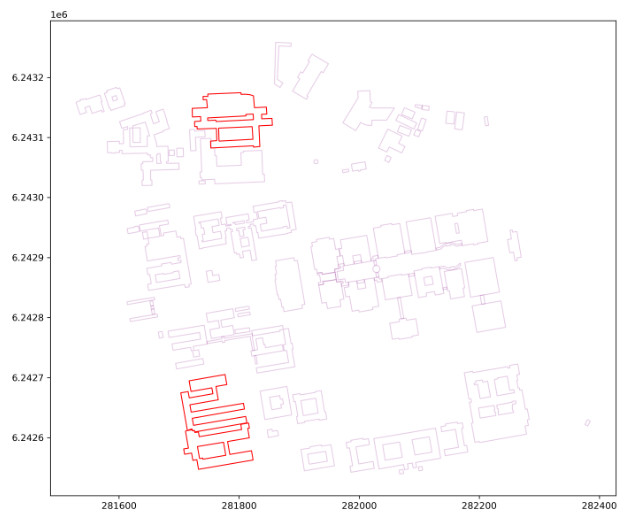| **Challenges will be highlight in *'Red'***|
| 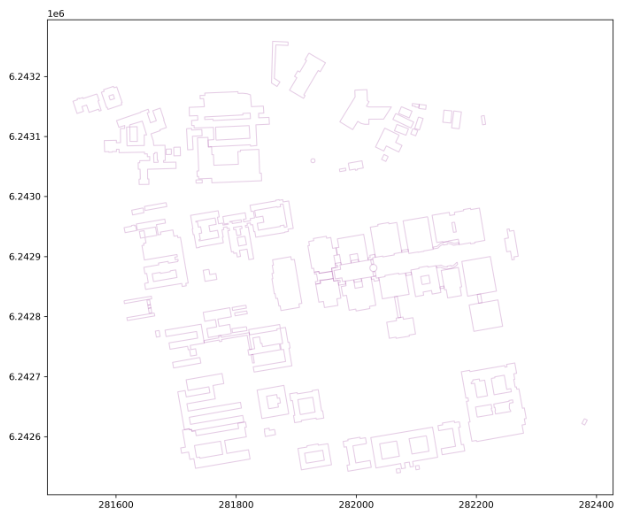| **or none**|

<h2><center> If you continue without fixing the challenges, the BVPC value will not be true.  <br /><br /> Our goal is to be as representative as possible. </center></h2>

**If necessary; edit [OpenStreetMap](https://www.openstreetmap.org/about) and fix the challenge please.** 

<div class="alert alert-block alert-warning"><b>  </b> 

And remember to give the the OpenStreetMap server at least a day before attempting the process again.
    
**Alchemy is a process. Please be patient.**
</div>

<div class="alert alert-block alert-success"><b>BVPC = total population of a community divided by sum of building volume</b></div>

In [78]:
#gdf['area'] = gdf['geometry'].to_crs('epsg:32734').area#\.map(lambda p: p.area)
#gdf['area'] = gdf['geometry'].to_crs(epsg).area#\.map(lambda p: p.area)
gdf['area'] = gdf['geometry'].area#\.map(lambda p: p.area)
gdf['volume'] = gdf['area'] * gdf['height']
gdf['bvpc'] =  gdf['volume'] / gdf['pop'] 

gdf.tail(2)

,geometry,coordinates,height,plus_codes,id,tags,level,city,suburb,street,housenumber,bld,bld_p,flats,res,amenity,combine,pop,area,volume,bvpc
2188,"POLYGON ((265305.077 6288750.422, 265302.872 6...","[[[18.4731684, -33.5150783], [18.4731456, -33....",4.1,4FRWFFMF+W7J,12289266,"{'addr:city': 'Cape Town', 'addr:housenumber':...",1,Cape Town,Mamre,Clarkeson Street,22,house,None,None,None,None,house,6,344.679759,1413.187012,235.531169
2189,"POLYGON ((266000.758 6288992.653, 265989.649 6...","[[[18.4807154, -33.5130481], [18.4805967, -33....",4.1,4FRWFFPJ+P7W,12357148,"{'addr:city': 'Cape Town', 'addr:housenumber':...",1,Cape Town,Mamre,Tol Street,2,house,None,None,None,None,house,6,327.808101,1344.013215,224.002202


In [79]:
print(gdf['bvpc'].describe())

count    1872.000000
mean       83.502892
std        53.222191
min        17.083175
25%        44.804768
50%        76.433019
75%       107.726081
max       729.782525
Name: bvpc, dtype: float64


In [80]:
bvpc = round(gdf['volume'].sum() / est_pop, 3)

print('Building Volume Per Capita (BVPC):', bvpc)

Building Volume Per Capita (BVPC): 83.292


<div class="alert alert-block alert-info"><b></b>

**This BVPC value is general.**  

We can seperate `building:house` and `building:residential` to undertand the differences between ***formal and informal*** housing in this area.
    
**We want to understand the living space *(the cubic-meter BVPC value)* each person has in thier home**
</div>

In [17]:
formal = gdf[gdf["combine"].isin(['house'])].copy()
f_pop = formal['pop'].sum()
#f_area = formal['area'].mean()

informal = gdf[gdf["combine"].isin(['residential'])].copy()
inf_pop = informal['pop'].sum()
#inf_area = formal['area'].mean()

bvpc_formal = round(formal['volume'].sum() / est_pop, 3)
bvpc_informal = round(informal['volume'].sum() / est_pop, 3)

print('FORMAL: Population: ', f_pop, ' with Building Volume Per Capita (BVPC):', bvpc_formal)
print('')
print('INFORMAL: Polutation: ', inf_pop, ' with Building Volume Per Capita (BVPC)', bvpc_informal)

FORMAL: Population:  9744  with Building Volume Per Capita (BVPC): 77.291

INFORMAL: Polutation:  732  with Building Volume Per Capita (BVPC) 6.112


***

**Now you do your community.** ~ If your area needs [OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap) data and you want to contribute please follow the [Guide](https://wiki.openstreetmap.org/wiki/Beginners%27_guide).